In [1]:
from functools import reduce
from itertools import repeat, product
from operator import or_, add
from random import randint
from collections import deque, defaultdict

import cv2
from matplotlib.pyplot import imshow, figure
import numpy as np
from numpy import array, flip, zeros_like

# pylint: disable=undefined-variable
%matplotlib inline

## Morphing

In [2]:
def cross(shape):
    return cv2.getStructuringElement(cv2.MORPH_CROSS, shape)

def circle(size):
    return cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (size, size))

def cvclose(image, kernel):
    return cv2.erode(cv2.dilate(image, kernel), kernel)

def constant_border(image, length, value):
    return cv2.copyMakeBorder(image, length, length, length, length, cv2.BORDER_CONSTANT, value=value)

# m-adjacent neighbors

 For a given image $I$ and a mask $M$, pixel $p, q$ are
 considered m-adjacent if one of the following is true
 
  1. $q$ is a 4-adjcent of $p$ where $p,q\in M$
  2. $q$ is diagonal of $q$ where $p, q\in M$ *and*
     there is no $\omega\in M$ where $\omega$ 
     is both 4-adjecent of $p$ and 4-adjecent of $q$


In [3]:
def is_in_image(pixel, shape):
    r, c = pixel
    rows, cols = shape
    return ((0 <= r < rows) and
            (0 <= c < cols))

def adjesent_m(pixel, mask):
    def is_in(pixel):
        r, c = pixel
        return is_in_image((r, c), mask.shape) and mask[r, c]
    
    def add_offset(offset):
        return tuple(map(add, pixel, offset))
    
    neighbors_4 = [offset
                   for offset in [(1, 0), (0, 1), (-1, 0), (0, -1)]
                   if is_in(add_offset(offset))]
    
    neighbors_diag = [(o_r, o_c)
                      for o_r, o_c in [(1, 1), (-1, 1), (-1, -1), (1, -1)]
                      if set([(0, o_r), (o_c, 0)]).isdisjoint(neighbors_4) and is_in(add_offset((o_r, o_c)))]
    
    return [add_offset(offset) for offset in neighbors_4 + neighbors_diag]

## Convertions

In [4]:
def uint8(image):
    return image.astype(np.uint8)

def arrayuint8(rows):
    return uint8(array(rows))

## Display

In [5]:
def imshow_gray(image, figsize=(50, 50)):
    figure(figsize=figsize)
    imshow(image, cmap='gray')
    
def as_display(image):
    return cv2.cvtColor(cv2.normalize(image.astype(np.float),
                                      None,
                                      0,
                                      255,
                                      cv2.NORM_MINMAX).astype(np.uint8),
                        cv2.COLOR_GRAY2RGB)

def rand_color():
    return (randint(150, 200), randint(150, 200), randint(0, 255))

def show_lines(image, lines, colors):
    image_with_lines = as_display(image)
    for ((point1, point2), color) in zip(lines, colors):
        cv2.line(image_with_lines, point1, point2, color, 1)
        
    return image_with_lines

def show_points(image, points, radius=2):
    image_with_circles = as_display(image)
    randcolor = (100, randint(150, 200), randint(0, 255))
    for point in points:
        cv2.circle(image_with_circles, point, radius, randcolor, thickness=-1)
    return image_with_circles

# Input

We get a text document as input

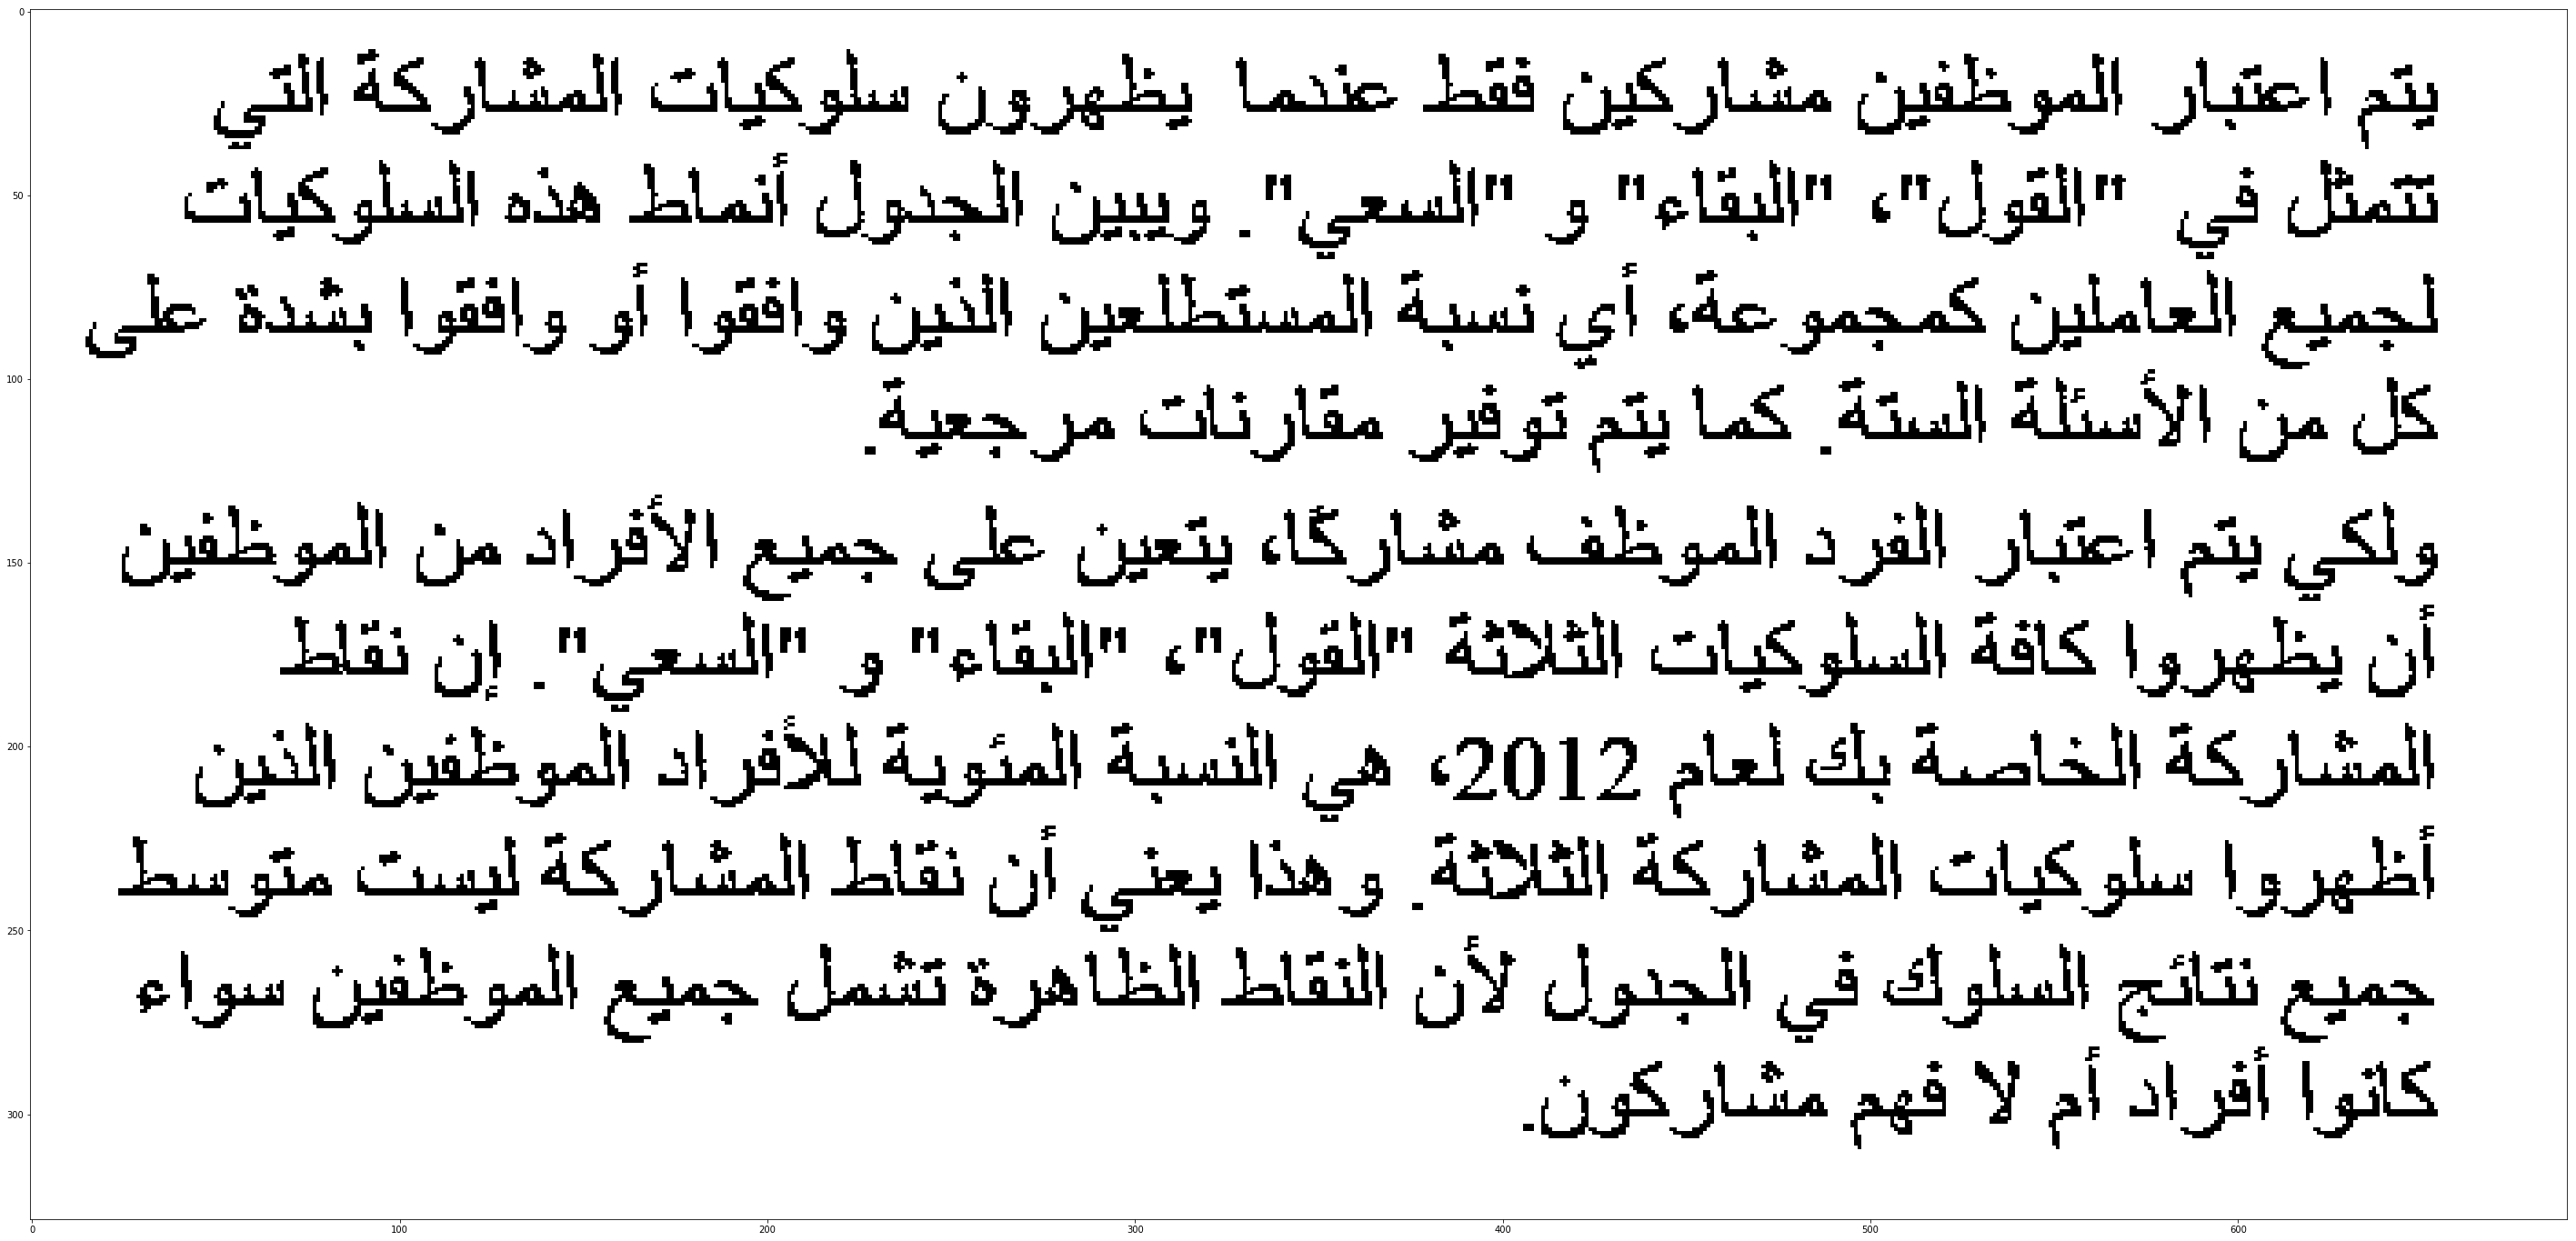

In [6]:
TEXT = cv2.threshold(src=cv2.imread("arabic.jpg", cv2.IMREAD_GRAYSCALE),
                     thresh=200,
                     maxval=1,
                     type=cv2.THRESH_BINARY)[1]

imshow_gray(TEXT)

# Ducument preprocessing
We erode input to emphasize words and add a black border to force graph edges at picture sides

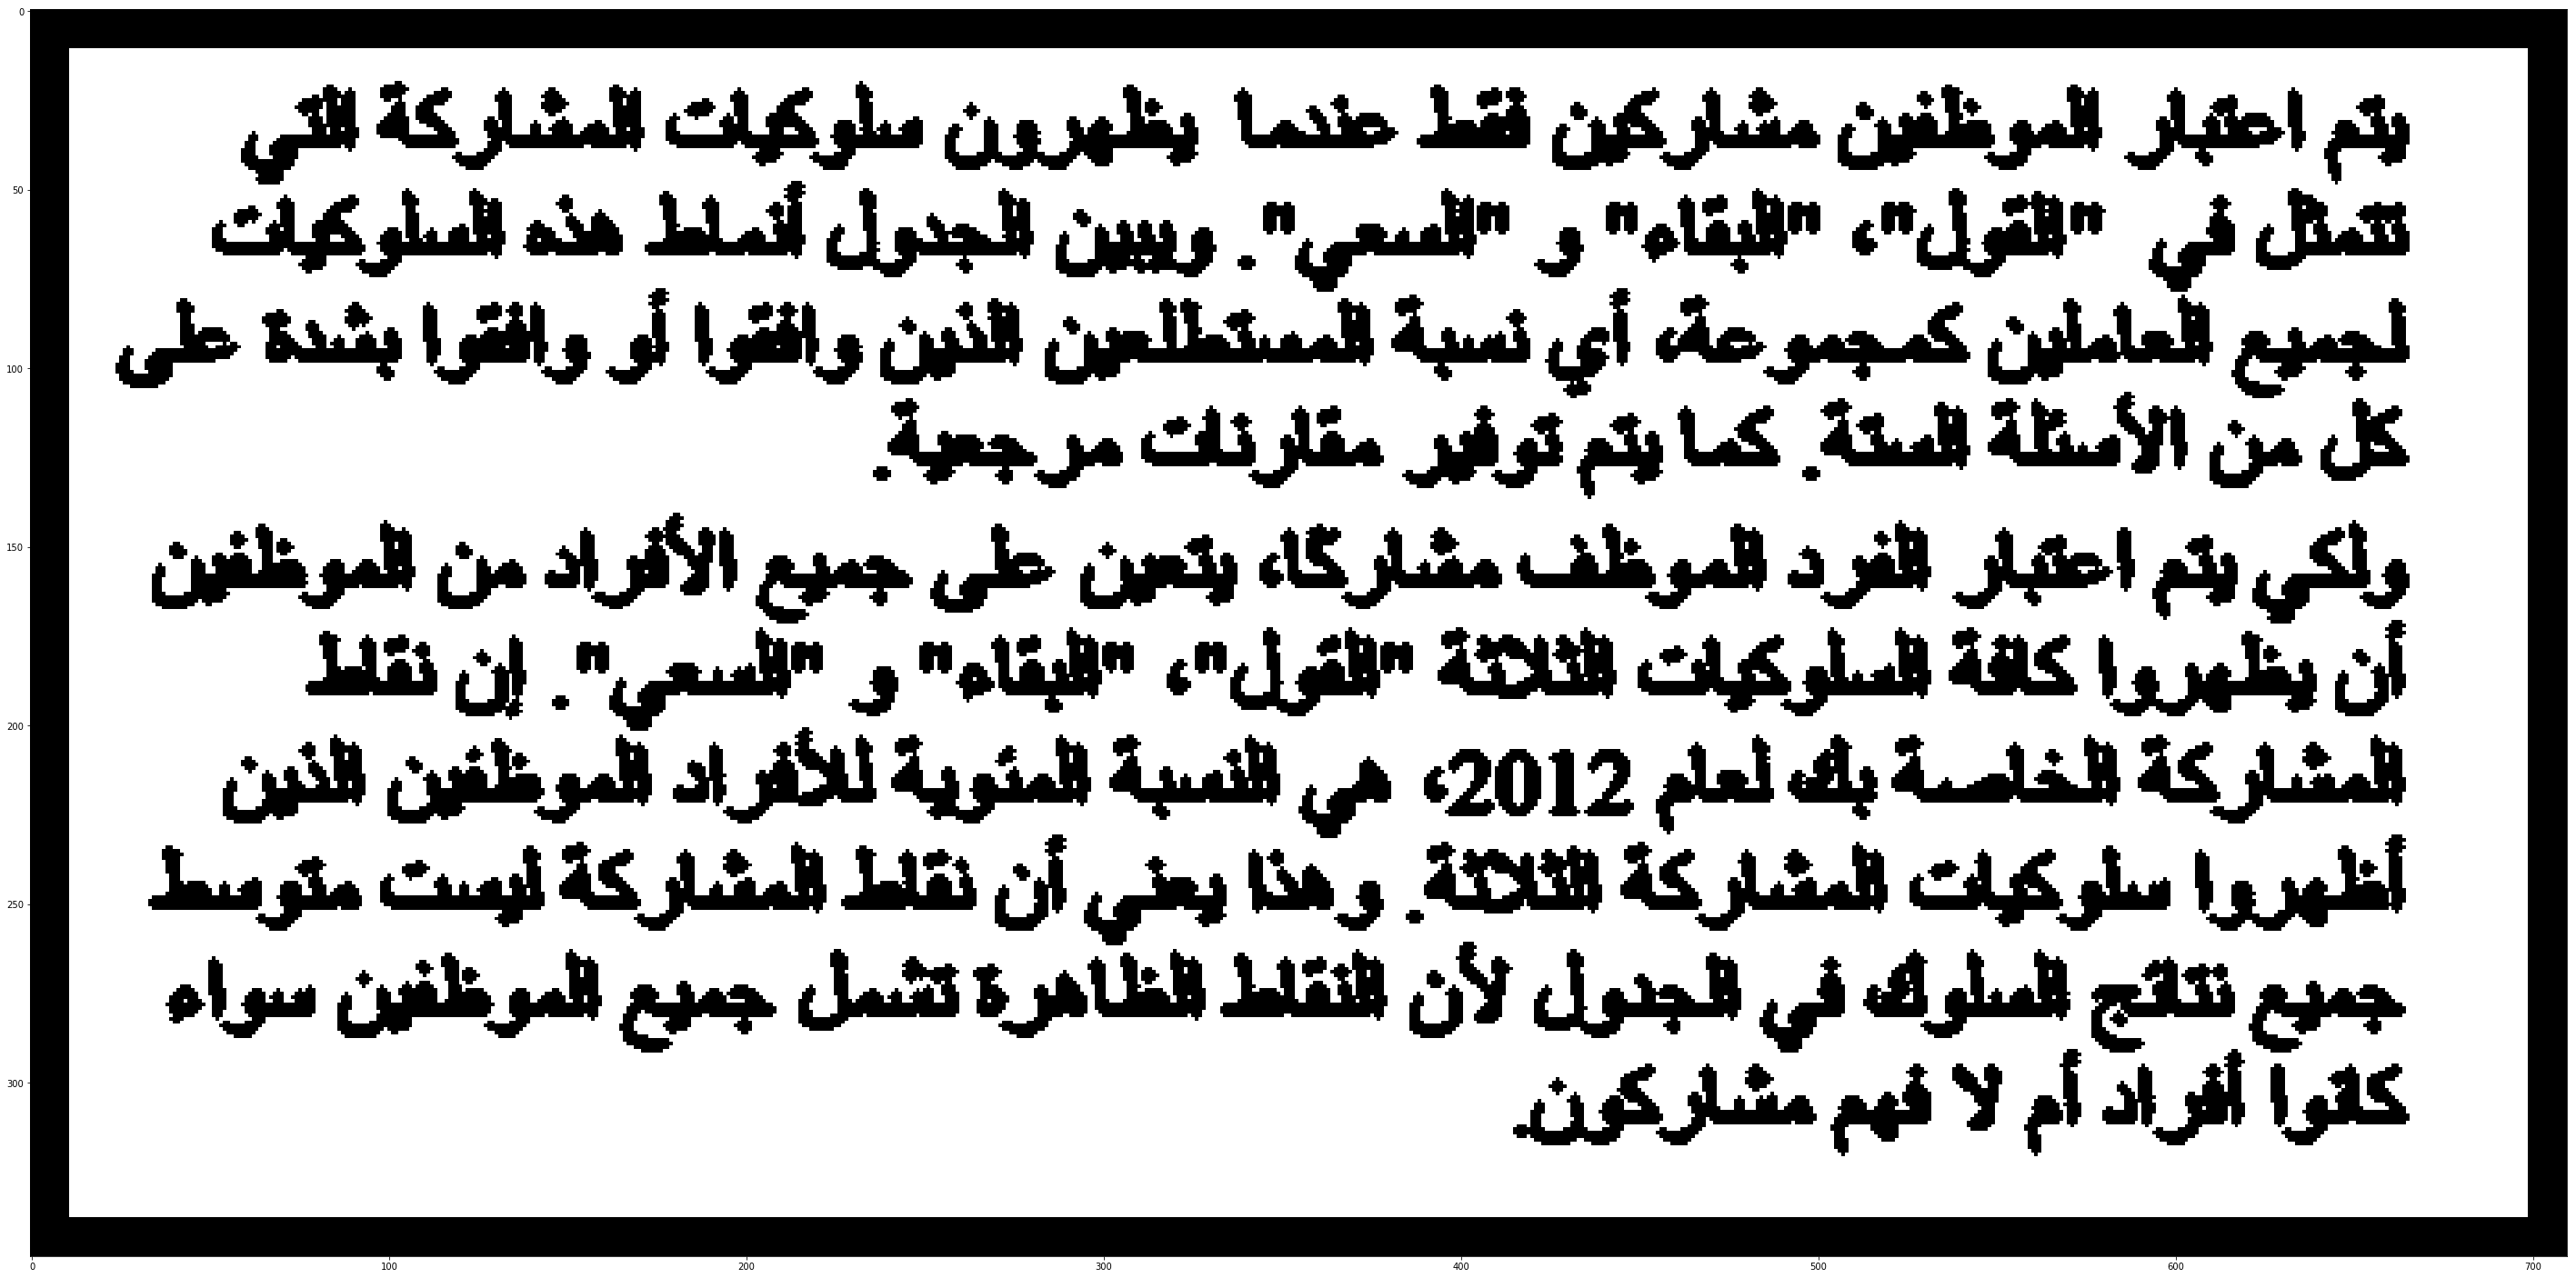

In [7]:
TEXT_SHOW = constant_border(TEXT, 10, 1)
TEXT_ERODE = cv2.erode(constant_border(TEXT, 10, 0), circle(3))
imshow_gray(TEXT_ERODE)

# Distance transform

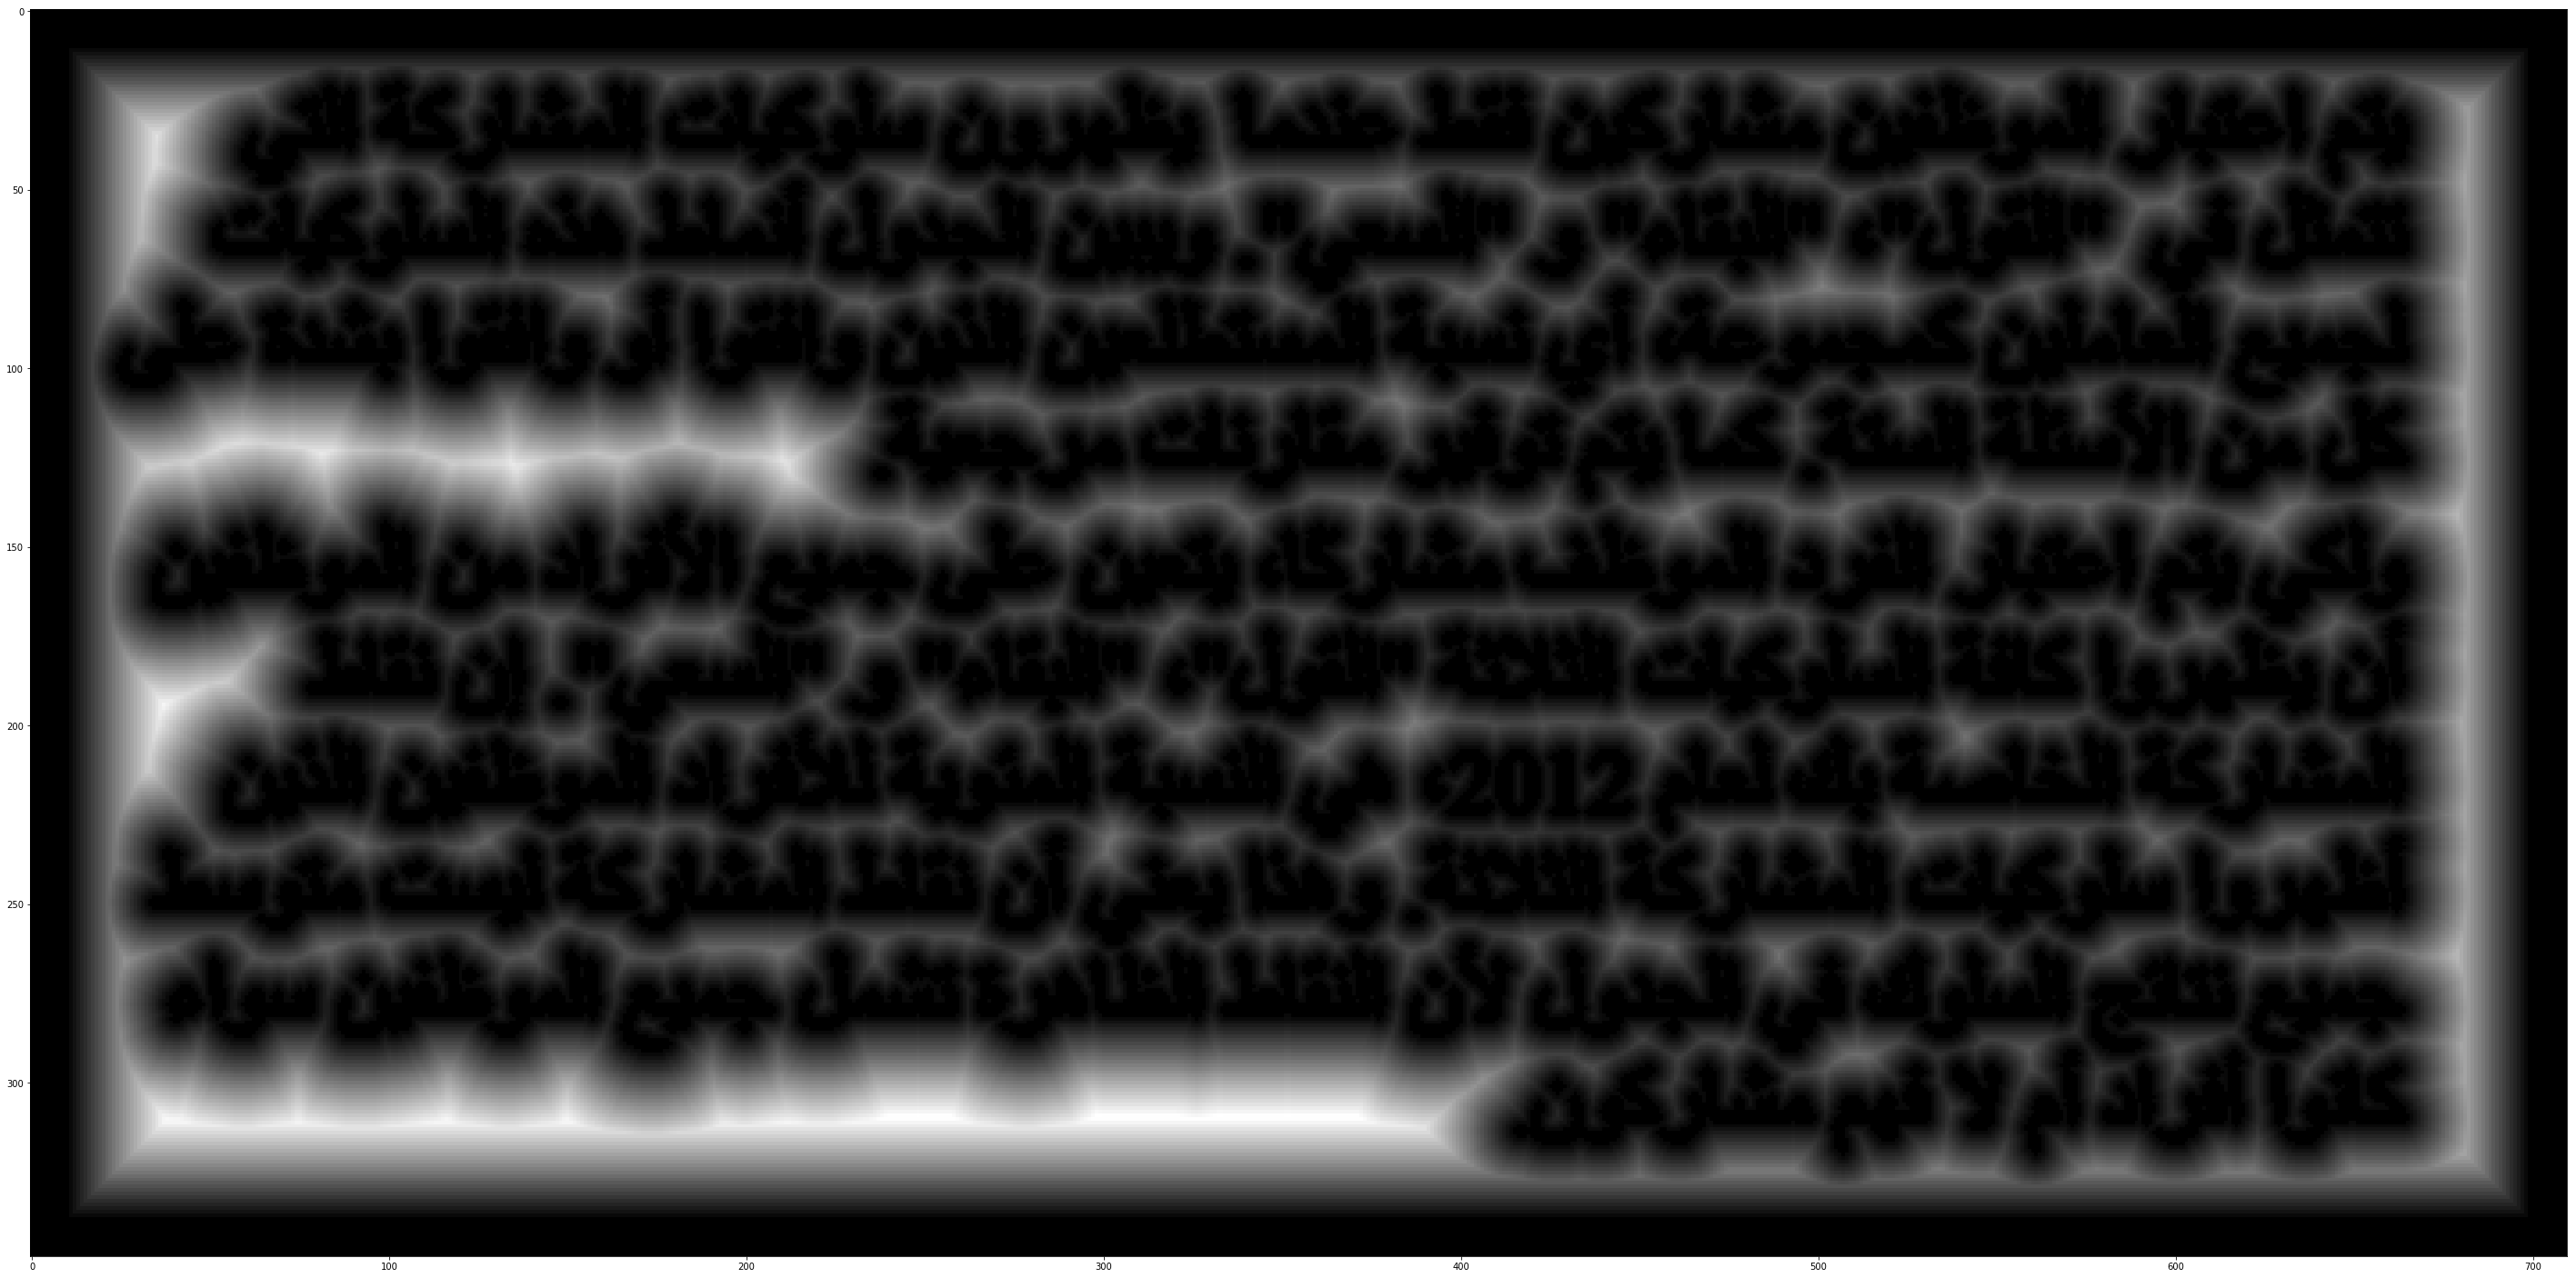

In [8]:
DIST = cv2.distanceTransform(TEXT_ERODE, cv2.DIST_L2, cv2.DIST_MASK_5)
imshow_gray(DIST)

# Local maxima

Each pixel $p$ is consider local maximum if $p > q_1 \wedge p> q_2$ where $q_1, q_2$ are opposite pixels in the 8-member inviroment of $p$

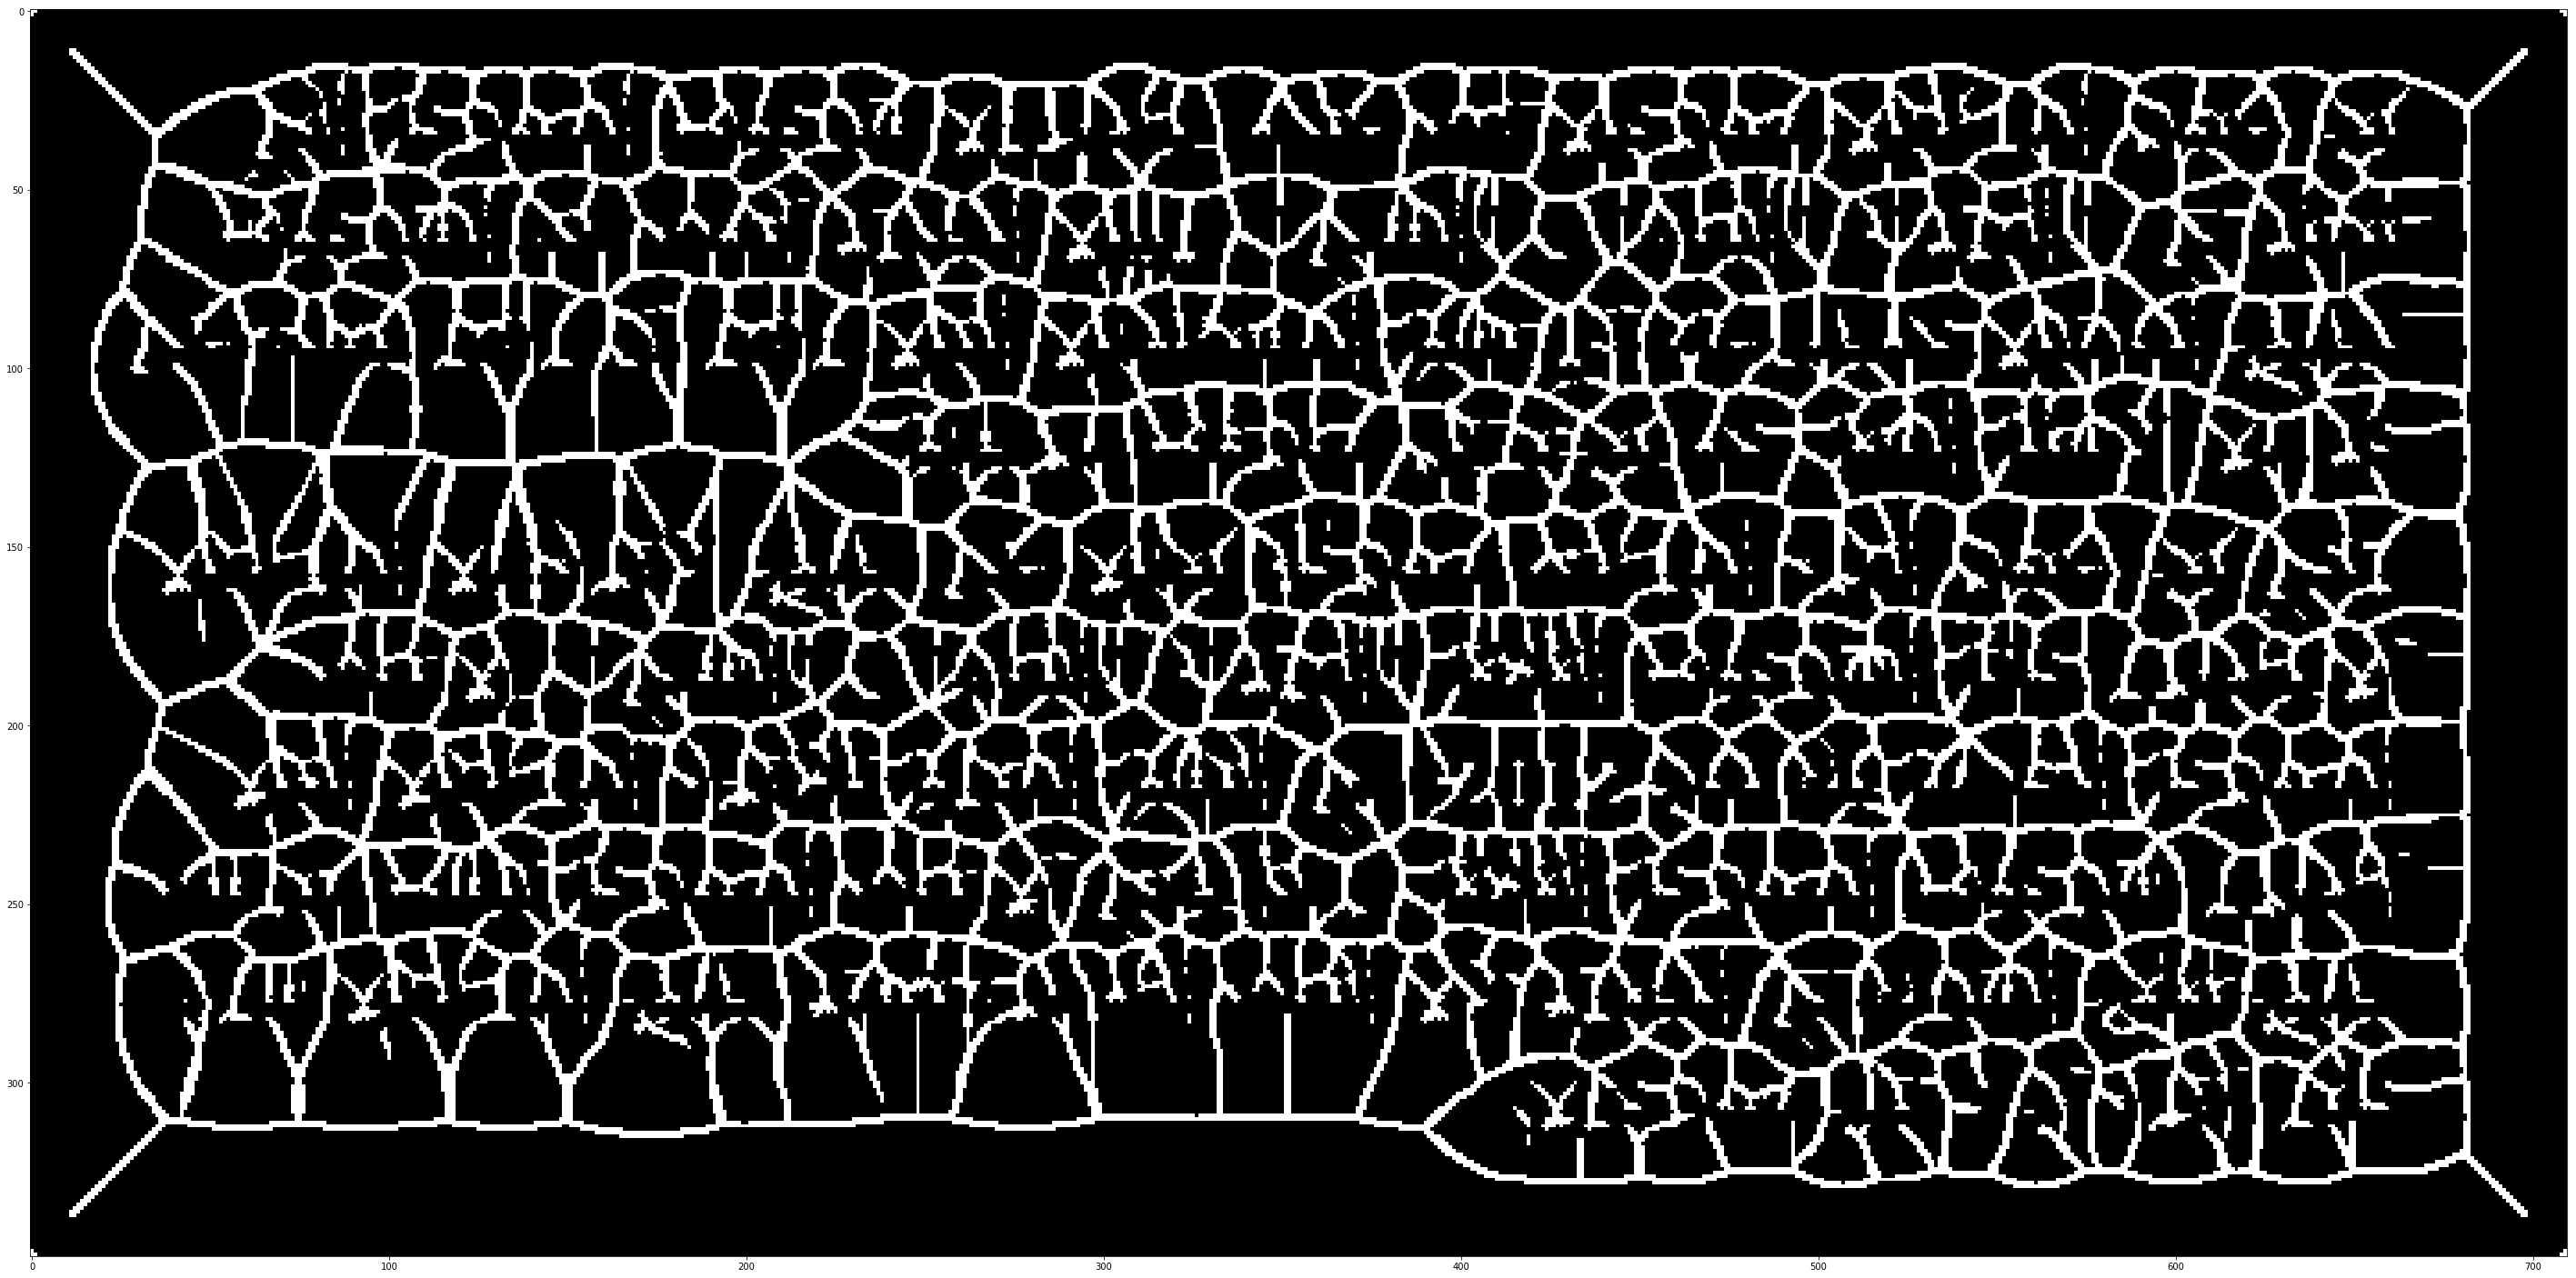

In [9]:
def local_maxima(image):
    
    horizontals = list(map(arrayuint8, [
        [
            [0, 0, 1, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 1, 0, 0]
        ],
        [
            [0, 1, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 1, 0]
        ],
    ]))
    
    horizontals_fliped = [flip(mat, 1) for mat in horizontals]
    

    kernels = [mat
               for matrices in [(mat, mat.T) for mat in horizontals + horizontals_fliped]
               for mat in matrices]

    local_maximas = (image > cv2.dilate(image, kernel)
                     for kernel in kernels)

    return uint8(reduce(or_, local_maximas))

LOCAL_DIST_MAXIMA = local_maxima(DIST)

imshow_gray(LOCAL_DIST_MAXIMA, figsize=(50, 50))

# Graph

We extract the vertices and the edges from the local maxima matrix

## Neighbor counting
1. For a pixel $p$ it is defined it has a neighbors in a direction $d$ , if it has non-zero pixels in that direction.
2. We count of number of directions a pixel has neighbors on. we get a number in $0\dots4$.

   e.g, a pixel with one neighbor (left) and a pixel with two neighbors(right):

   $\begin{pmatrix}0&0&0&0&0\\0&0&0&0&0\\0&0&\textbf{p}&0&0\\0&0&1&0&0\\0&0&1&0&0 \end{pmatrix}$
   $\qquad$
   $\begin{pmatrix}0&0&0&0&0\\0&0&0&0&0\\0&0&\textbf{p}&1&1\\0&0&1&0&0\\0&0&1&0&0 \end{pmatrix}$

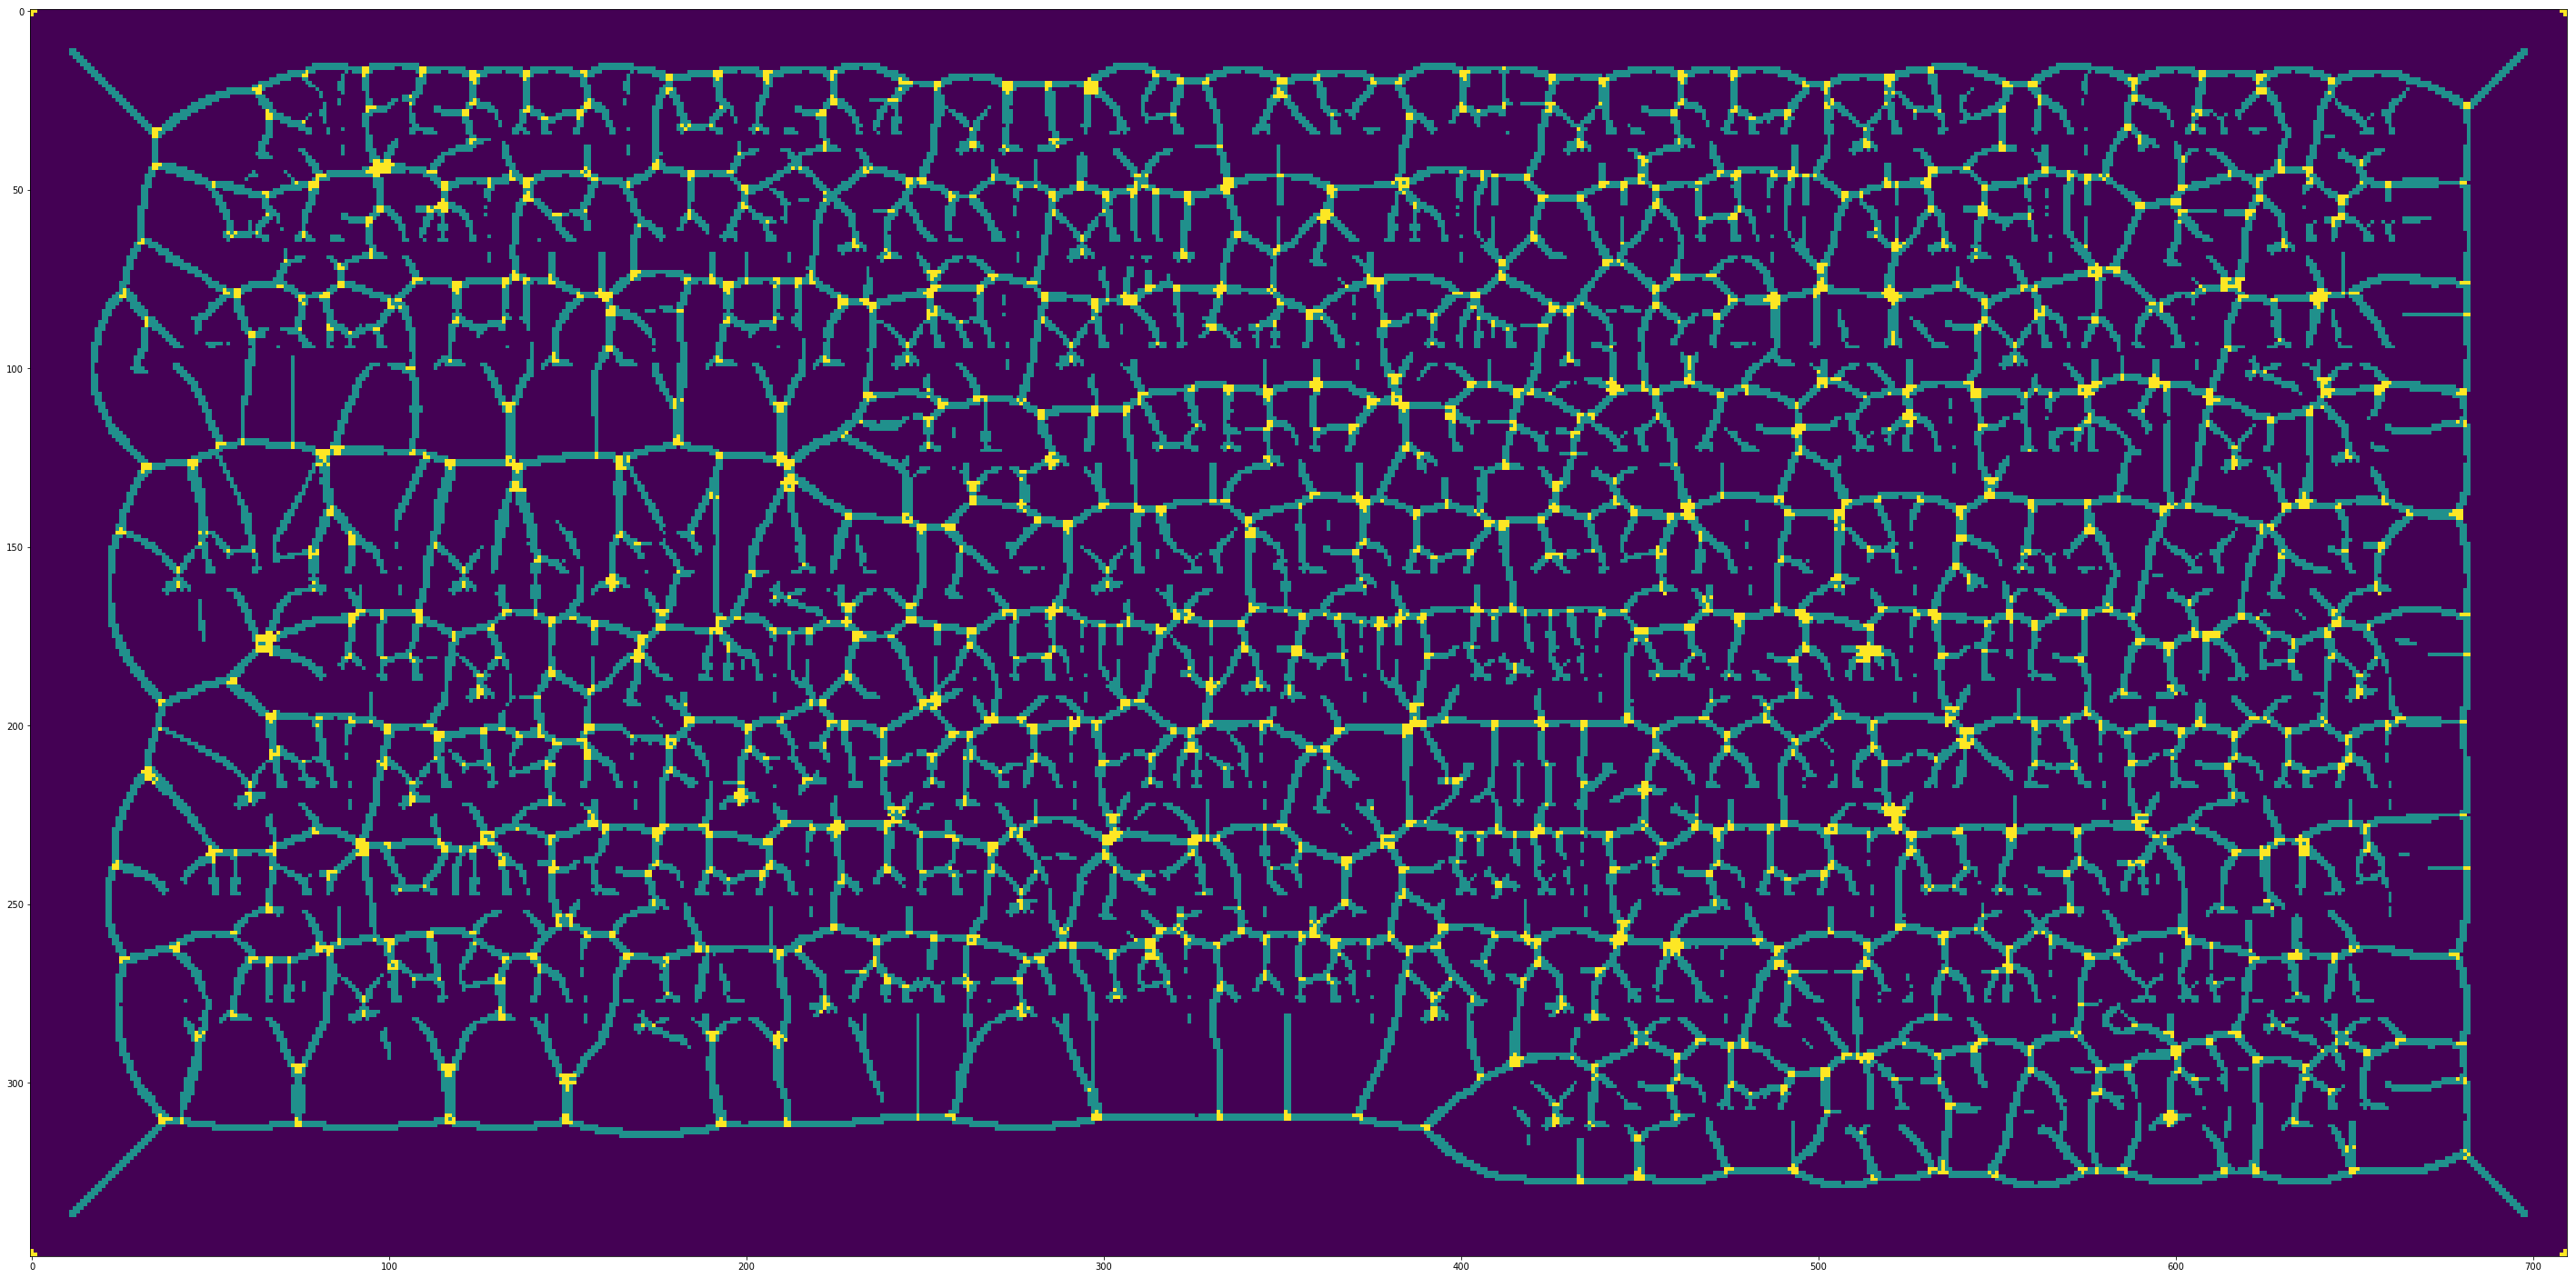

In [10]:
def rotations(mat):
    return (mat, mat.T, flip(mat, 0), flip(mat.T, 1))

def vertice_candidates(binary):
    junctions = map(arrayuint8, [
        [
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [1, 1, 1, 1, 1],
            [0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [1, 0, 0, 0, 0],
            [0, 1, 0, 0, 0],
            [0, 0, 1, 1, 1],
            [0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [1, 0, 0, 0, 1],
            [0, 1, 0, 1, 0],
            [0, 0, 1, 1, 0],
            [0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 1, 0, 0],
            [1, 1, 1, 1, 1],
            [1, 0, 1, 0, 1],
            [0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0],
        ]
    ])

    rotated_mats = (rotated
                    for mat in junctions
                    for rotated in rotations(mat))

    def filter_junction(junction):
        return cv2.erode(binary, junction)

    return reduce(or_, map(filter_junction, rotated_mats), zeros_like(binary))

imshow(LOCAL_DIST_MAXIMA + vertice_candidates(LOCAL_DIST_MAXIMA),
       figure=figure(figsize=(50, 50)))

## Centeroids
1. Let $FM$ be pixels $p$ with [neighbor count](#Neighbor-counting) $n(p) > 2$ 
2. Graph vertices are defined as the centeroids of connected components of $FM$ 

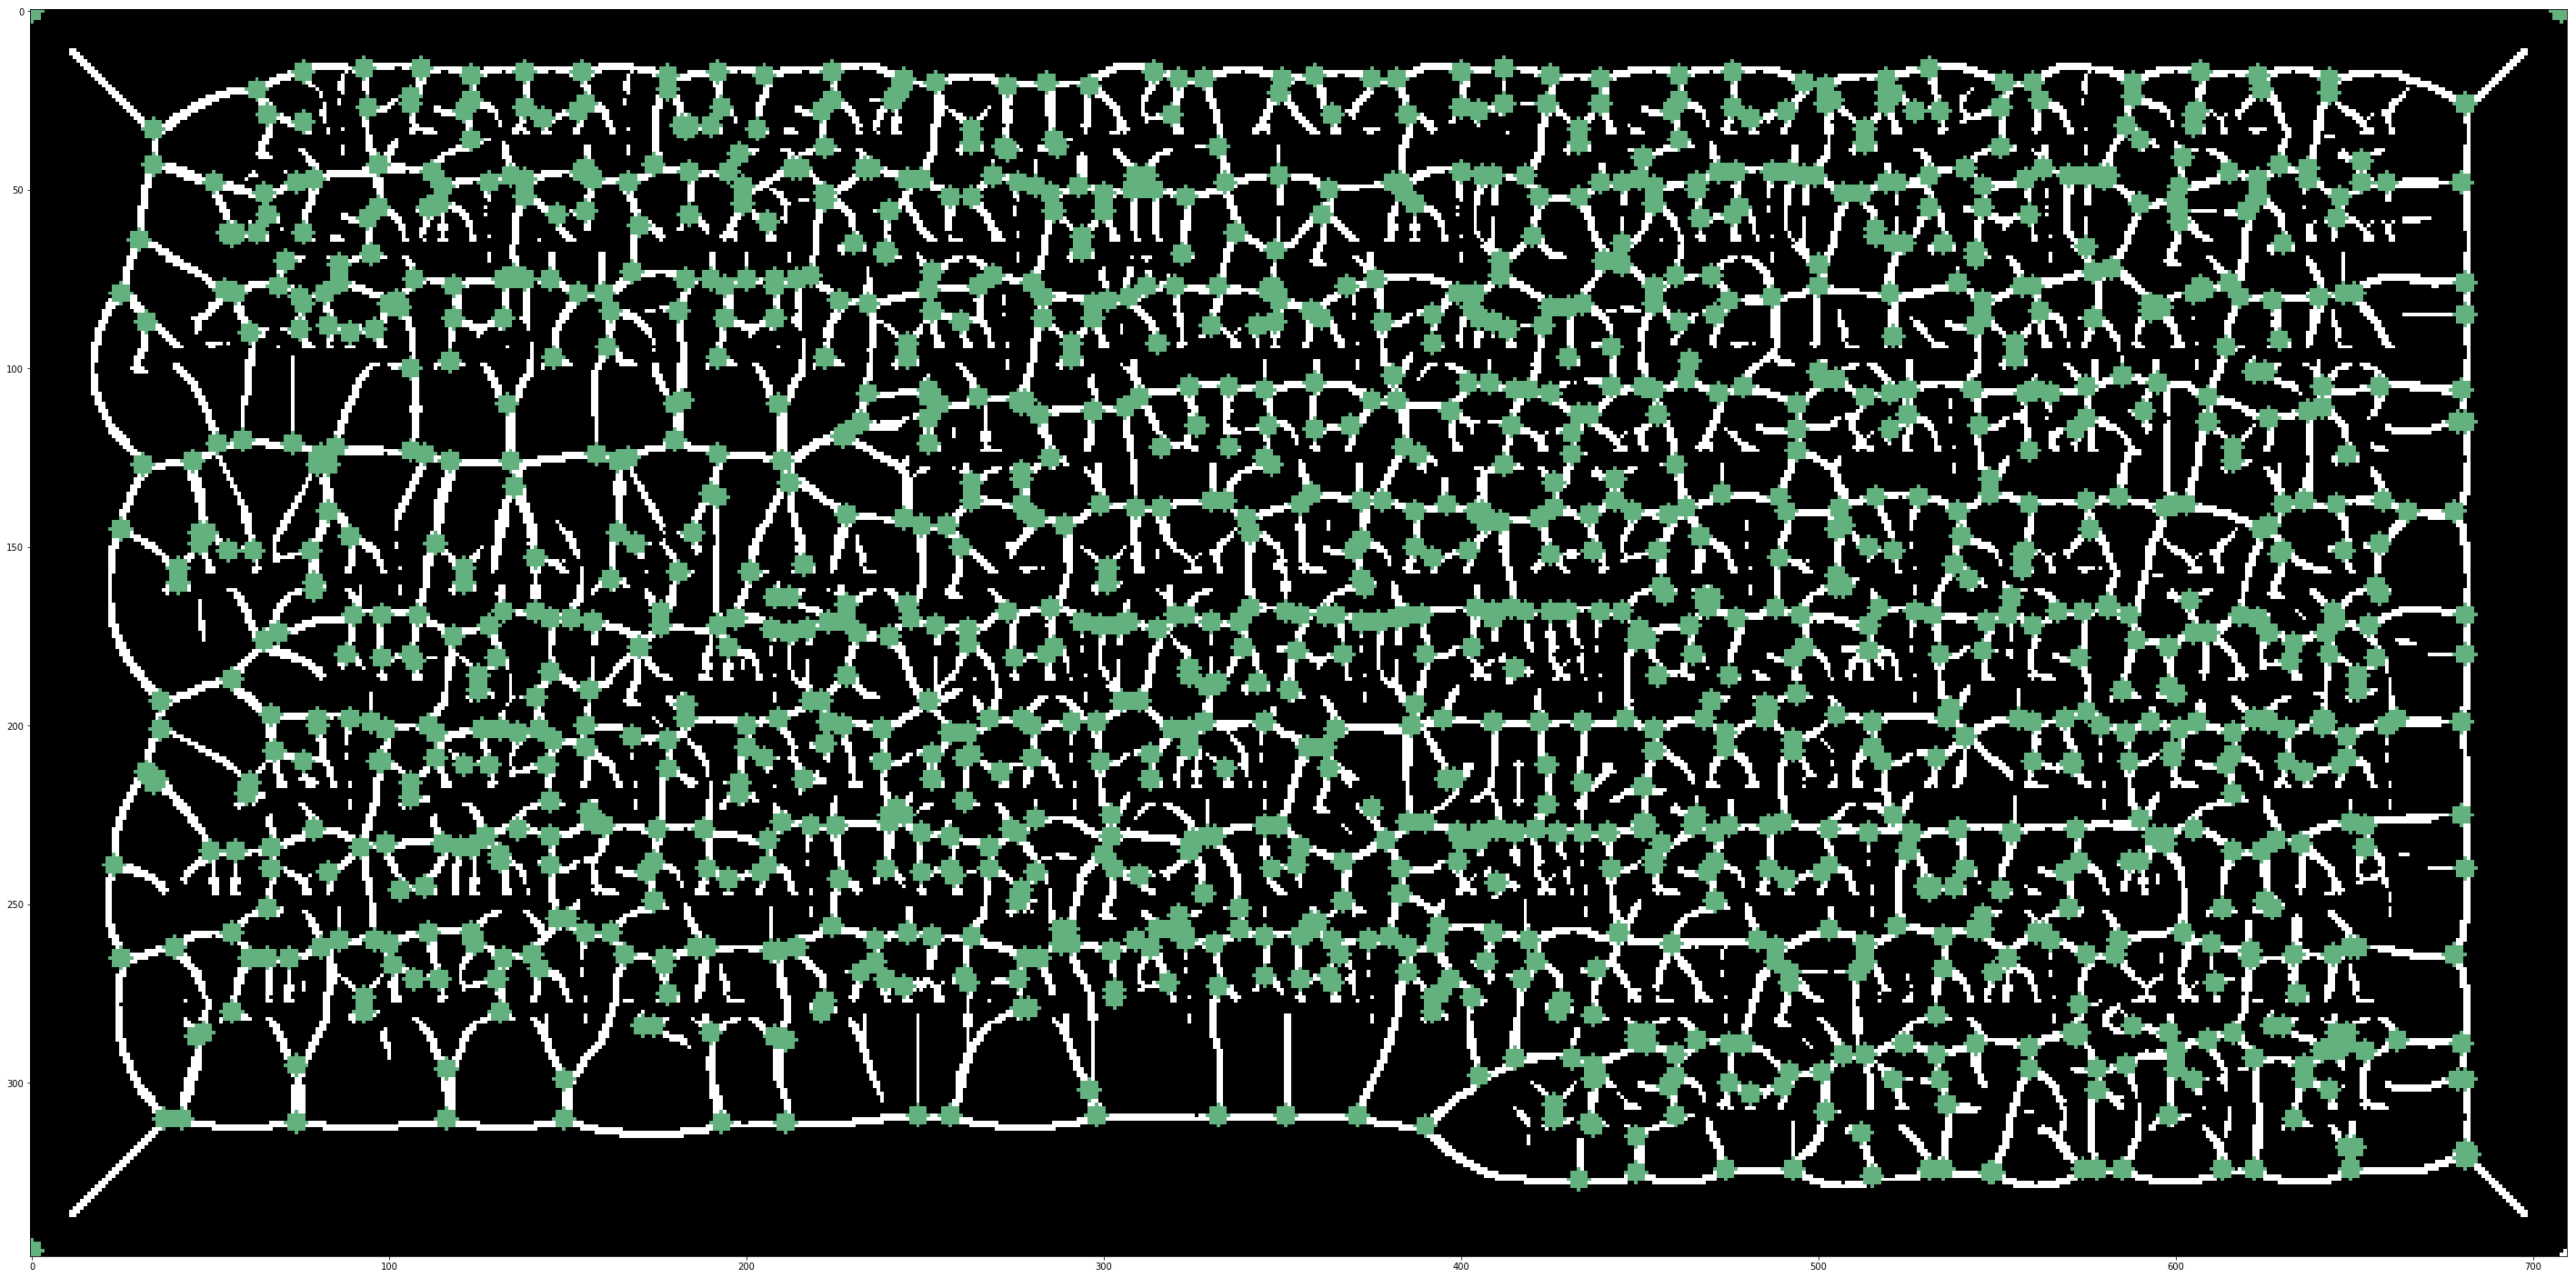

In [11]:
def vertices(skeleton):
    vertex_pixels = vertice_candidates(skeleton)
    centeroids = cv2.connectedComponentsWithStats(
        vertex_pixels,
        connectivity=4
    )[-1]
    return [tuple(map(int, point)) for point in centeroids[1:-1]]


LOCAL_MAX_VERTS = vertices(LOCAL_DIST_MAXIMA)
imshow(show_points(LOCAL_DIST_MAXIMA, LOCAL_MAX_VERTS, 3),
       figure=figure(figsize=(50, 50)))

 # Edges

## BFS
* We define set $C=$ [centeroids](#Centeroids)
* While $C\neq \emptyset$
  - Start from some $c \in C$ and set $C = C - \{c\}$
  - Perform a bfs scan on [local maxima](#Local-maxima)
  - Define current graph vertice as closest vertice at the curr pixels $p$ rectangle enviroment of some $r$
  - If found vertice is different than pervious found vertice in scan, we add an edge connecting curr vertice to found one

In [12]:
def area_to_vert(verts, radius):
    return dict((point, (x, y))
                for (x, y) in verts
                for point in product(range(x - radius, x + radius),
                                     range(y - radius, y + radius)))

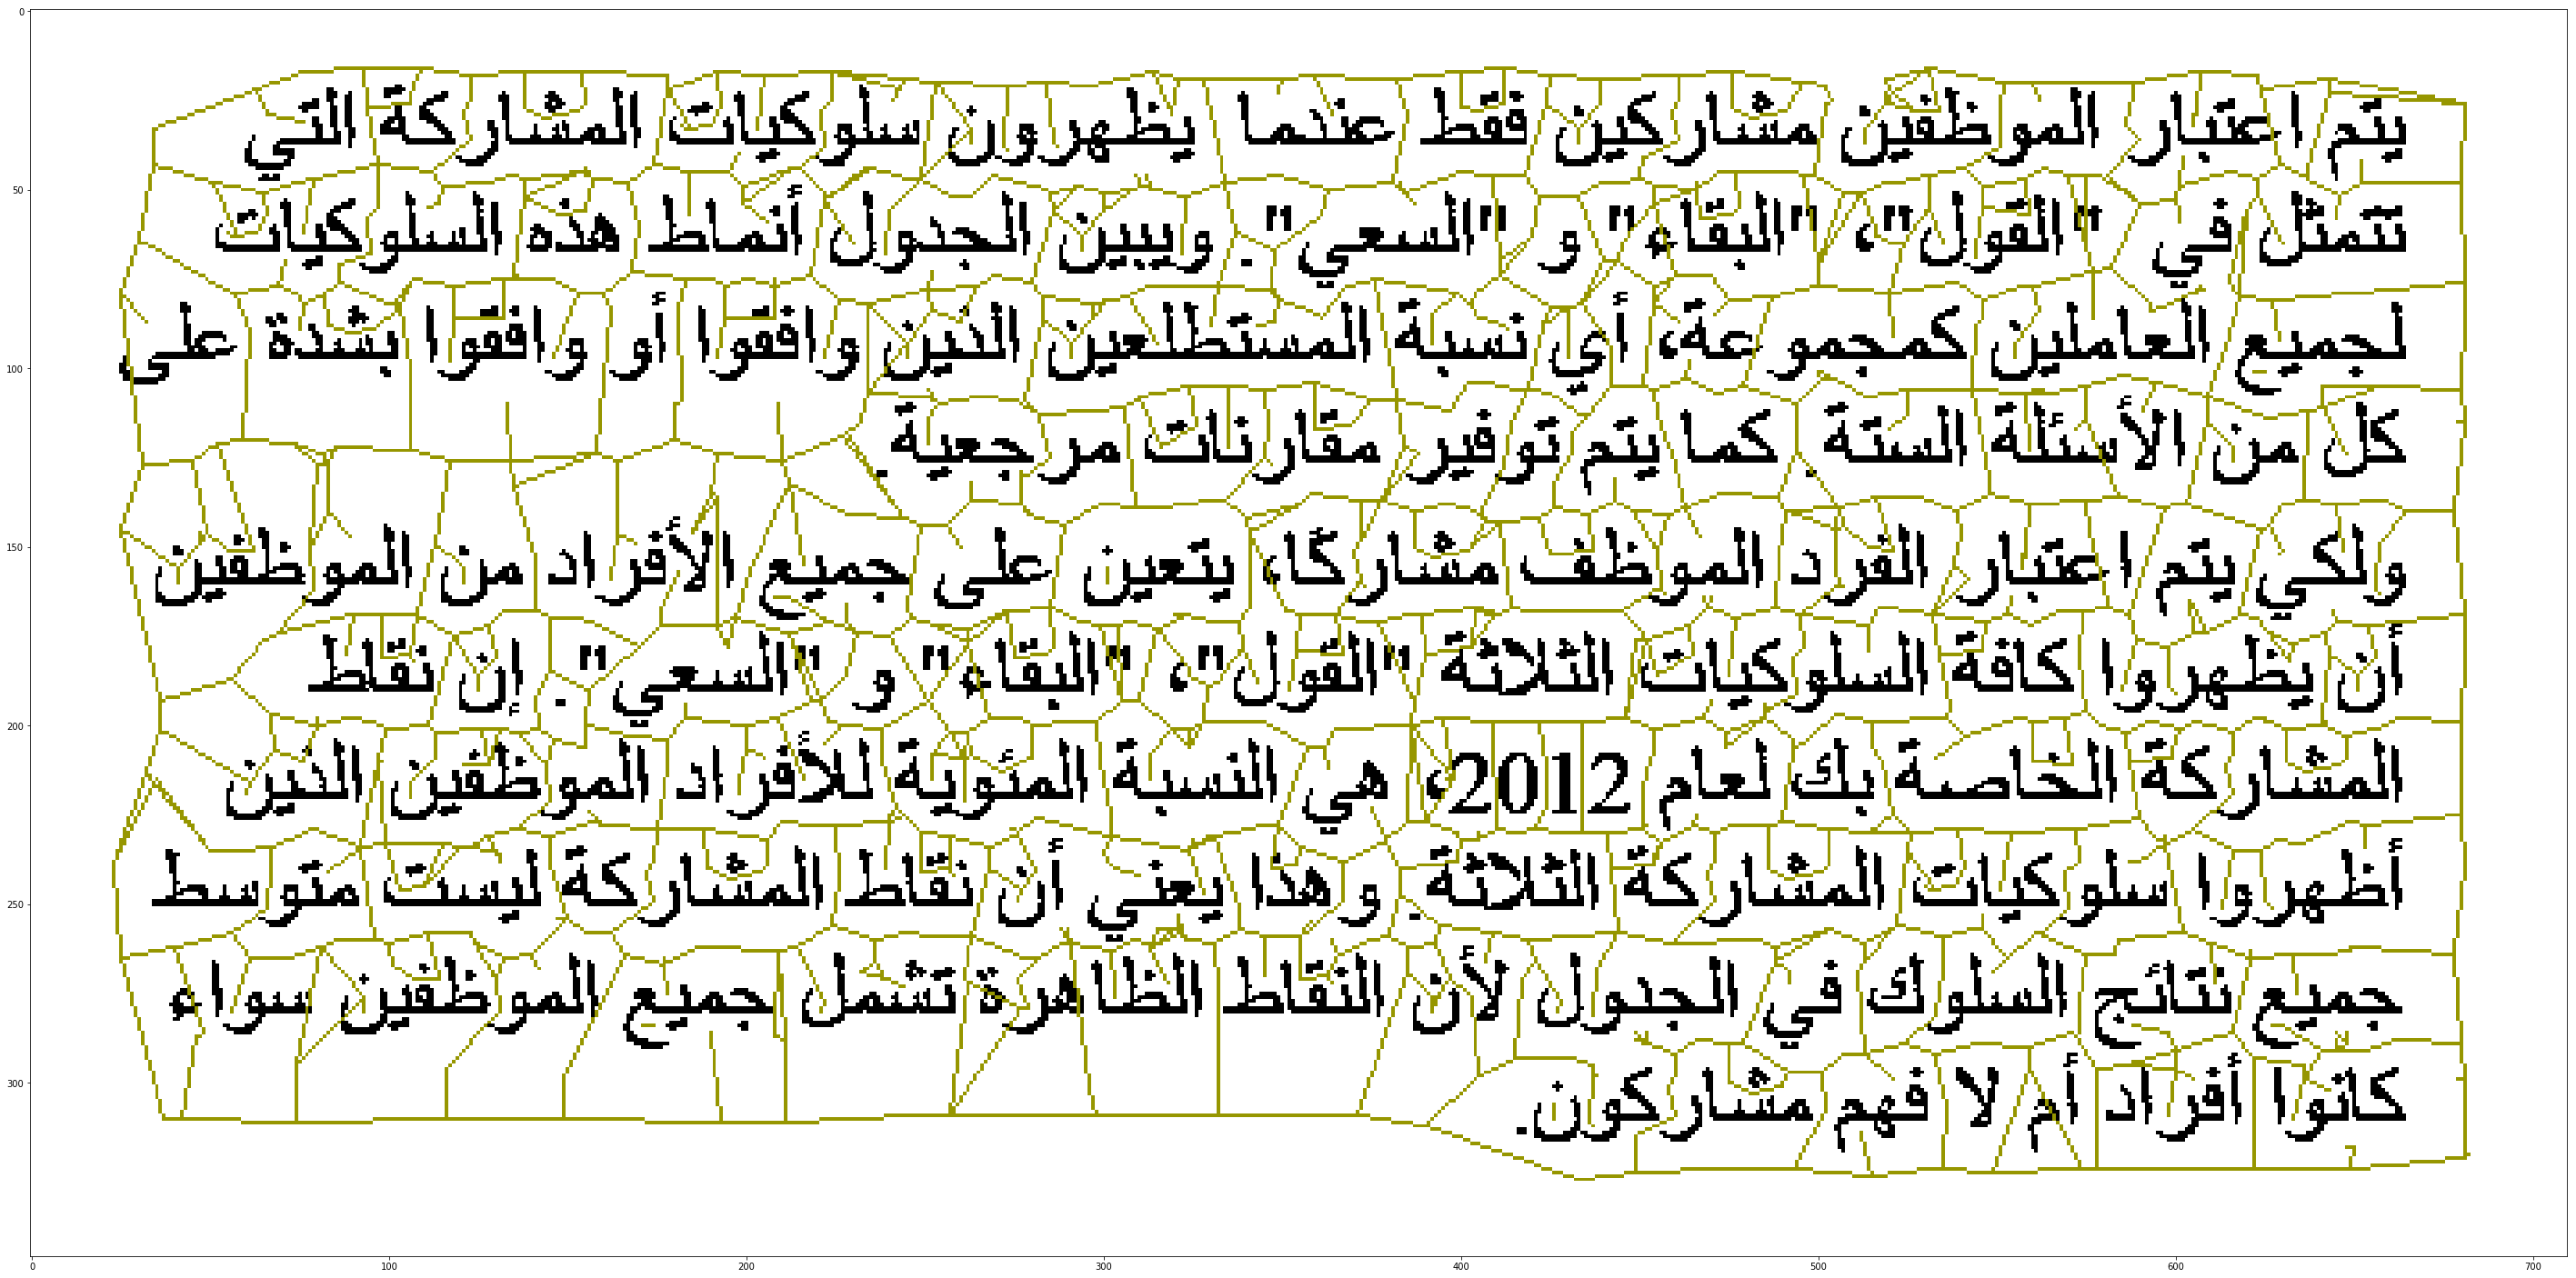

In [13]:
def build_graph(search_mask, covermap, verts):
    unvisited_vertices = verts.copy()

    graph = defaultdict(set)

    while unvisited_vertices:
        unvisited = search_mask.copy()
        start = unvisited_vertices.pop()
        bfs_q = deque([start])
        while bfs_q:
            pos = bfs_q.popleft()
            vert = covermap.get(pos, start)

            if start == vert:
                nextvs = adjesent_m(pos, unvisited)
                for r, c in nextvs:
                    unvisited[r, c] = 0
                bfs_q.extend(nextvs)
            else:
                graph[start].add(vert)
                graph[vert].add(start)
    return graph


def edges(graph):
    return set(tuple(sorted(((c1, r1), (c2, r2))))
               for (r1, c1), connecetd in graph.items()
               for (r2, c2) in connecetd)

ROW_INDEX_VERTS = [(c, r) for r, c in LOCAL_MAX_VERTS]
GRAPH = build_graph(
    search_mask=LOCAL_DIST_MAXIMA,
    covermap=area_to_vert(ROW_INDEX_VERTS, 4),
    verts=set(ROW_INDEX_VERTS))

imshow(show_lines(TEXT_SHOW, edges(GRAPH), repeat((150, 150, 0))),
       figure=figure(figsize=(50, 50)))

# Remove leafs

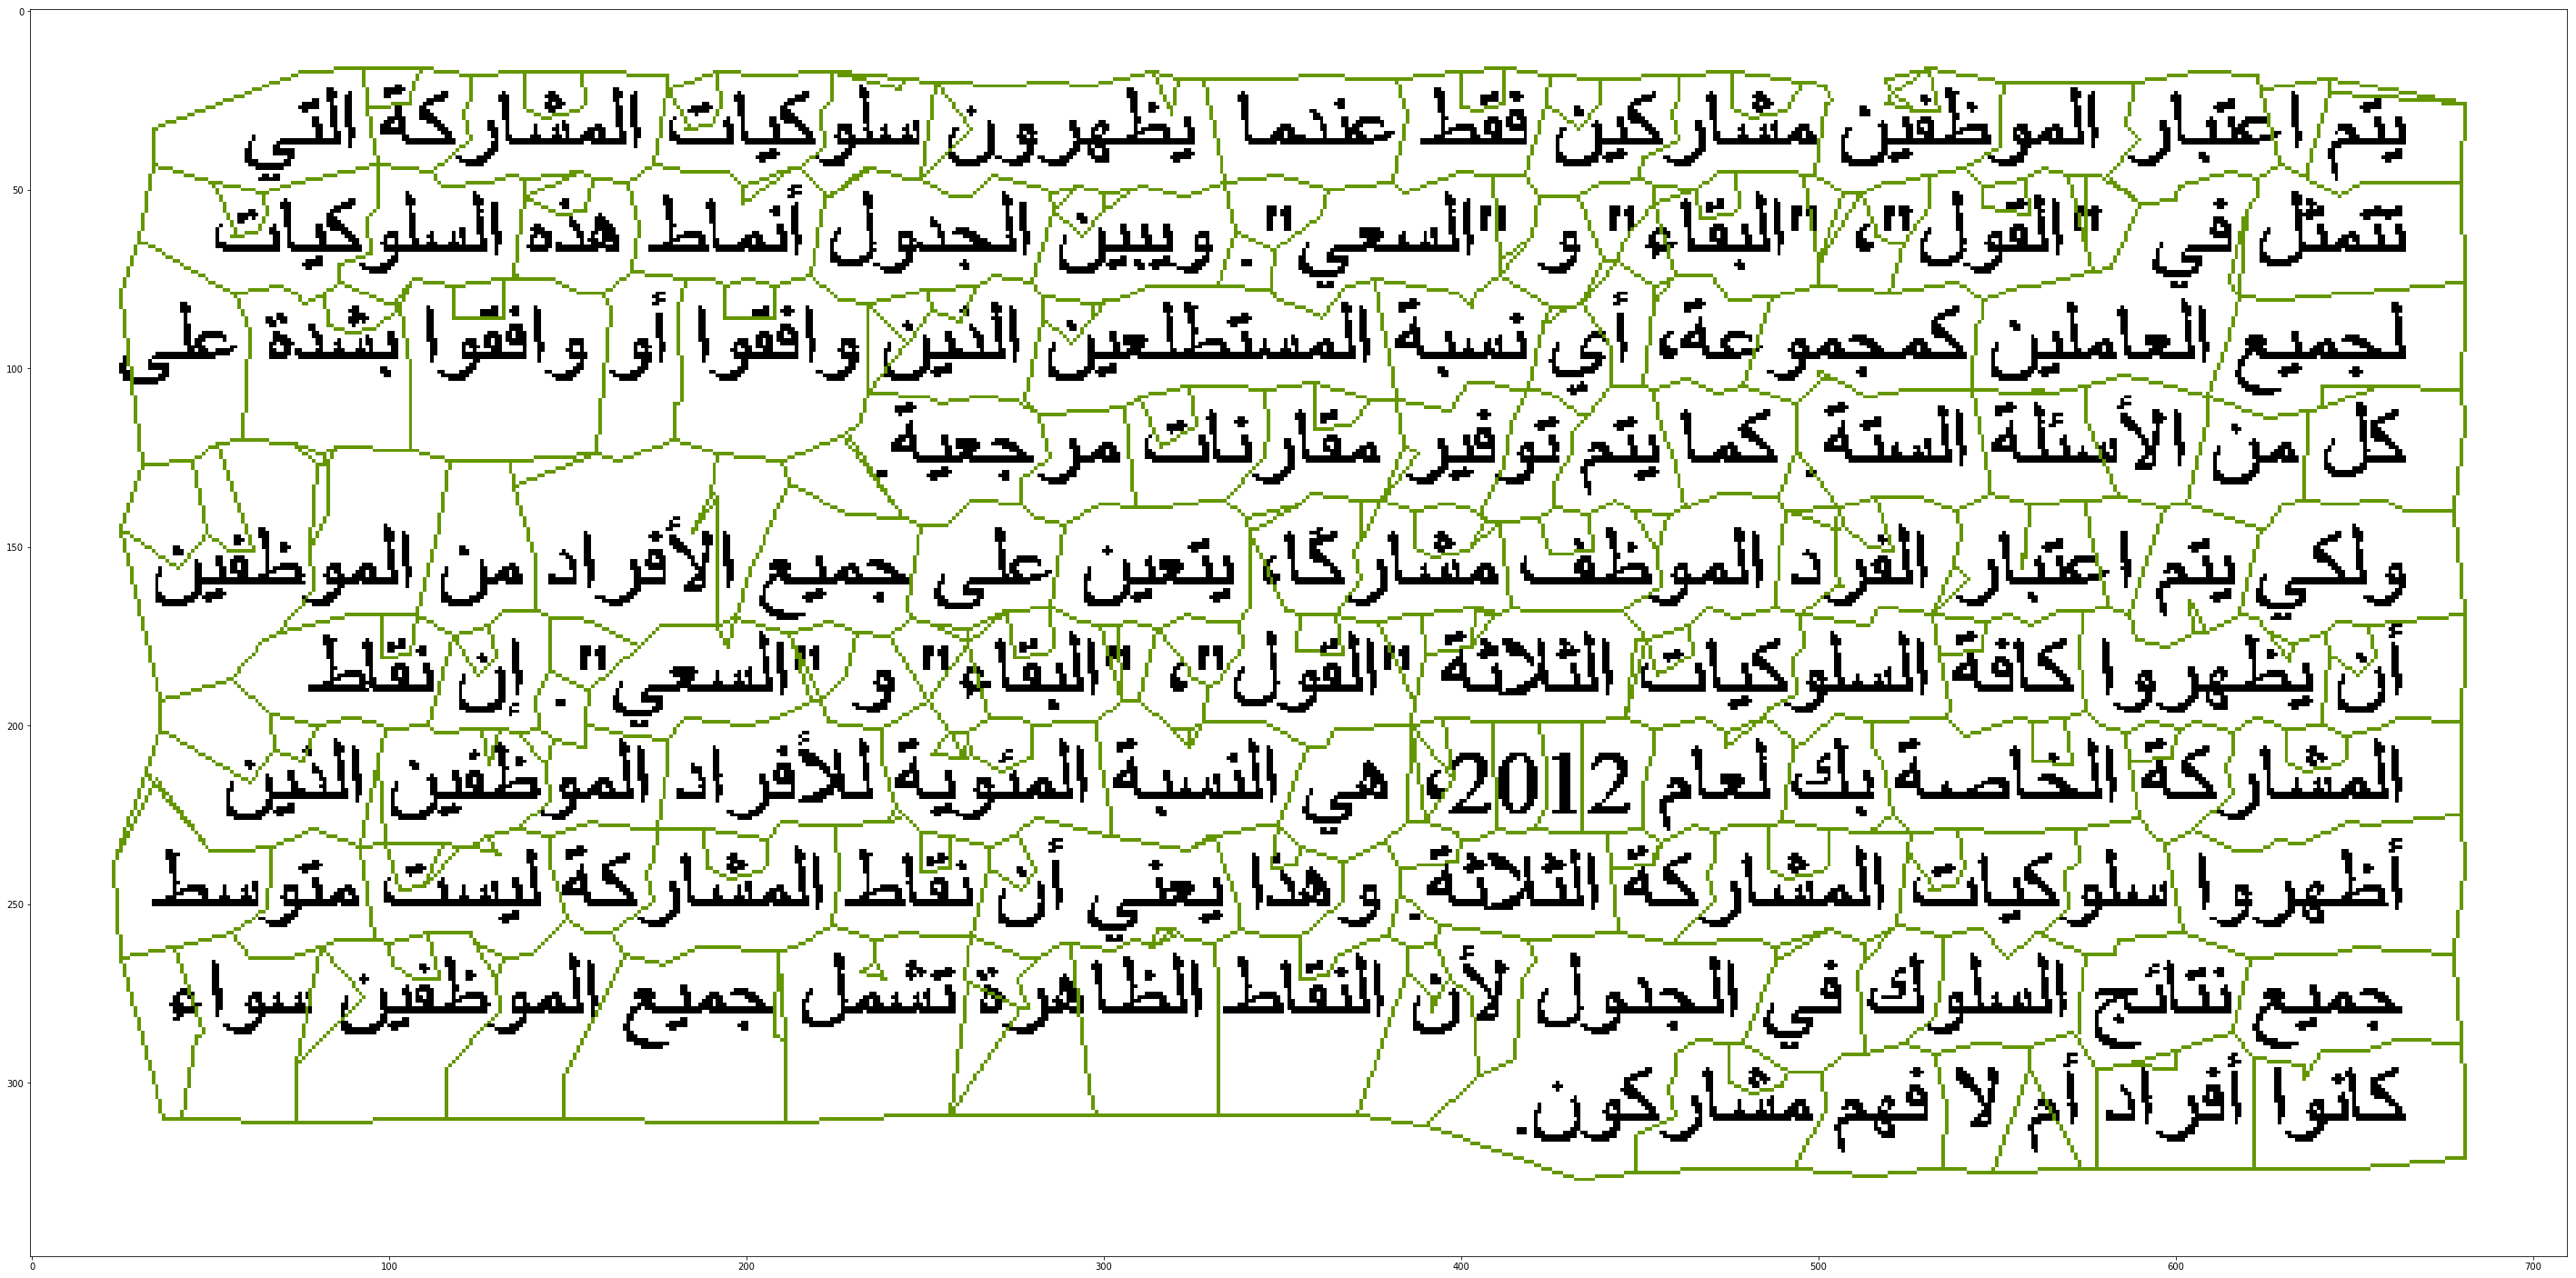

In [14]:
def clear_leafs(graph):
    while True:
        leafs = set([v for v, connected in graph.items() if len(connected) <= 1])

        if not leafs:
            return

        for leaf in leafs:
            graph.pop(leaf)

        graph.update((vert, neighbors - leafs)
                     for vert, neighbors in graph.items())

clear_leafs(GRAPH)
imshow(show_lines(TEXT_SHOW, edges(GRAPH), repeat((100, 150, 0))),
       figure=figure(figsize=(50, 50)))